<a href="https://colab.research.google.com/github/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center><b><u>Model Building</u></b></center> </h3>
<h4><center><b>Prepared By: Simranjeet Randhawa</b></center> </h4>
<h4><center><b>Student ID: 200412297</b></center> </h4>




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

<h3> 1. Model Building </h3>
<p align="justify">
 In this phase, I will develop datasets for training and testing purposes. Moreover I will consider whether your existing tools will suffice for running the models or it will need a more robust environment (like fast and parallel processing). I will analyse different models on the data and thereby choose the one with minimum mean square error and higher accuracy.
 </p>

In [0]:

query = """
SELECT  * from `hello.CombinedData`
"""
df2 = client.query(query).to_dataframe()

In [0]:
df1groupby = df1[['zone_id','time','pickups']].groupby(['zone_id','time','pickups'])

In [0]:
data=df2

In [0]:
data["zone_id"] = data["zone_id"].astype(int)

In [0]:
data.drop('zone_id', axis=1, inplace=True)

In [0]:
import pandas as pd
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum() # Resmapling the time series data with month starting first.
# Train-Test splitting of time series data


In [11]:
data.head()

,pickups
time,
2018-01-01 00:00:00+00:00,231546.0
2018-01-02 00:00:00+00:00,233052.0
2018-01-03 00:00:00+00:00,261087.0
2018-01-04 00:00:00+00:00,119818.0
2018-01-05 00:00:00+00:00,259731.0


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


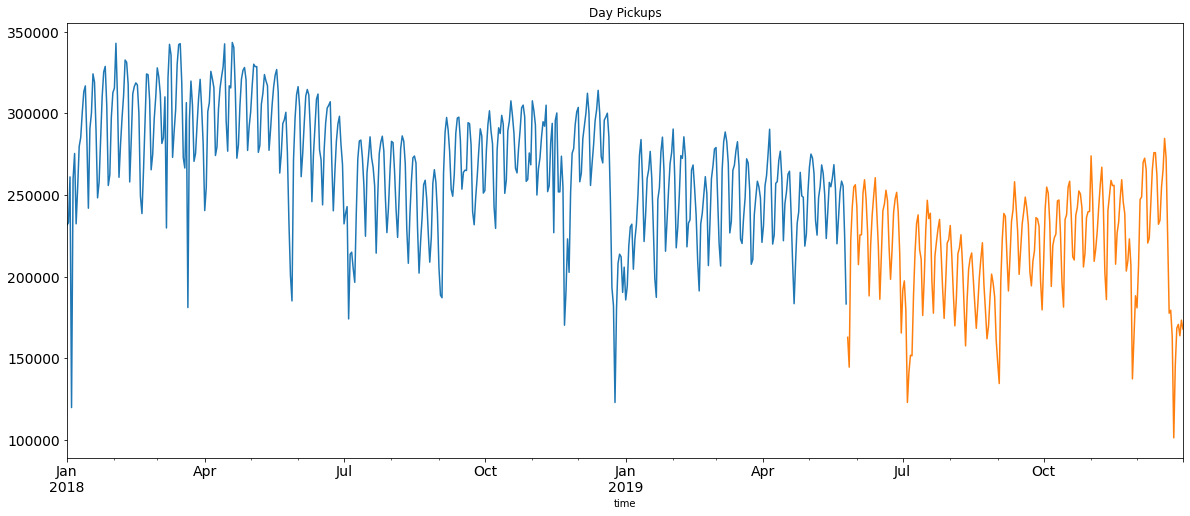

In [19]:
import matplotlib.pyplot as plt
train_data = data[:int(0.7*(len(data)))]
test_data = data[int(0.7*(len(data))):]
# ARIMA takes univariate data.
train_data = train_data['pickups']
test_data = test_data['pickups']
# Plot of Weekly_Sales with respect to years in train and test.
train_data.plot(figsize=(20,8), title= 'Day Pickups ', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Day Pickups', fontsize=14)
plt.show()

In [0]:
data = data.fillna(method='ffill')

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['pickups'])
print('p-value is calculated as: {}'.format(result[1]))

p-value is calculated as: 0.35010313377312674


In [17]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 2.7MB/s 


In [0]:
# Applying auto_arima model on train data.
from pyramid.arima import auto_arima
model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,stepwise=False, suppress_warnings=True, D=1, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)

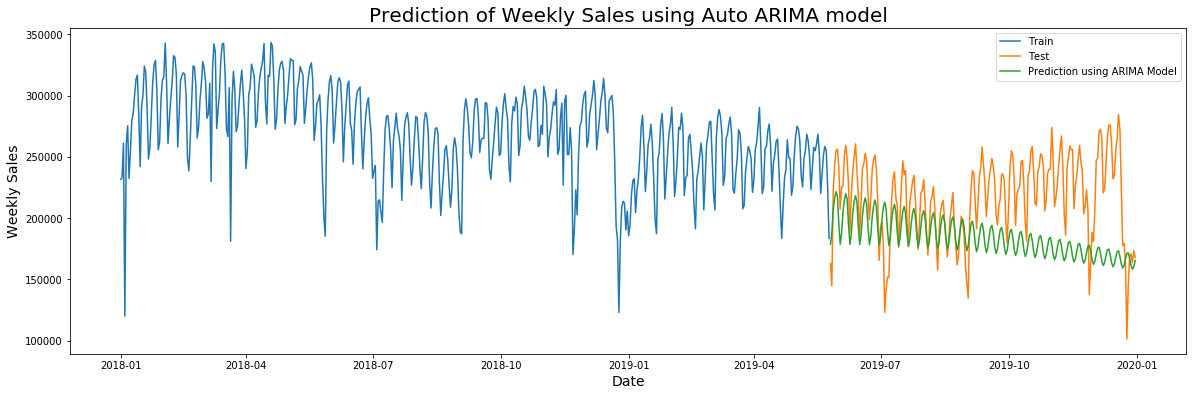

In [0]:
import matplotlib.pyplot as plt
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Pickups', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [0]:
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

In [0]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


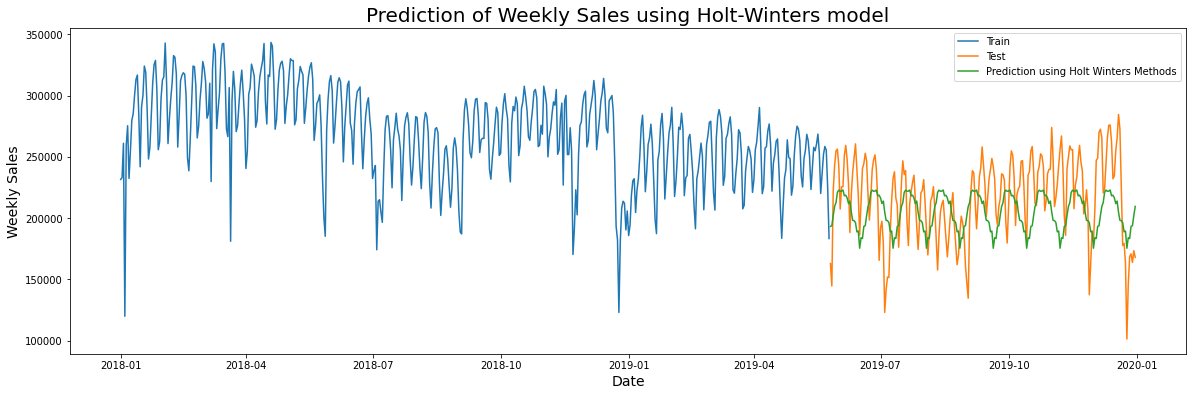

In [20]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=24, seasonal='additive' ).fit() 
pred = model_holt_winters.forecast(len(test_data))# Predict the test data
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [27]:
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Mean Squared Error (MSE) of Holt-Winters:  1216368857.8772552
Root Mean Squared Error (RMSE) of Holt-Winters:  34876.48000984697
Mean Absolute Deviation (MAD) of Holt-Winters:  28822.247778329813


Trying

In [0]:
a=df2

In [0]:
a.head()

,zone_id,time,pickups
0,7,2018-01-01 13:00:00+00:00,14.0
1,7,2018-01-04 12:00:00+00:00,14.0
2,7,2018-01-04 13:00:00+00:00,14.0
3,7,2018-01-05 21:00:00+00:00,14.0
4,7,2018-01-06 13:00:00+00:00,14.0


In [0]:
data=df2

In [0]:
a=df2
a = a.resample('D').sum()
ts=a.groupby(["time"])["pickups"].sum()


In [0]:
df2=a.groupby(["time"])["pickups"].sum().reset_index()

 

In [0]:
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum()

In [31]:
data.head()

,pickups
time,
2018-01-01 00:00:00+00:00,231546.0
2018-01-02 00:00:00+00:00,233052.0
2018-01-03 00:00:00+00:00,261087.0
2018-01-04 00:00:00+00:00,119818.0
2018-01-05 00:00:00+00:00,259731.0


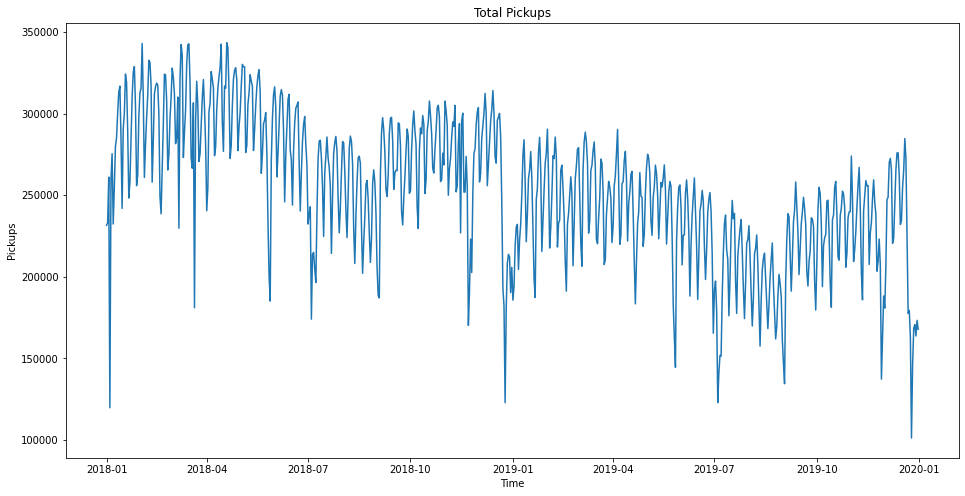

In [33]:
ts=data.groupby(["time"])["pickups"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Pickups')
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.plot(ts);

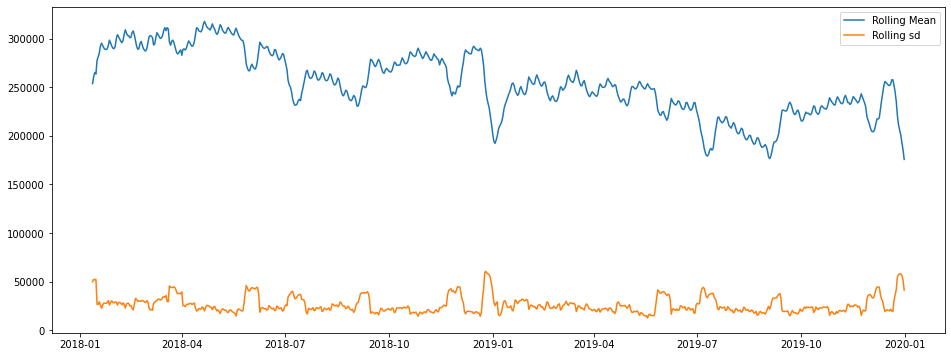

In [34]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

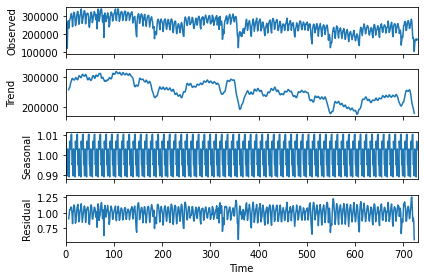

In [35]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

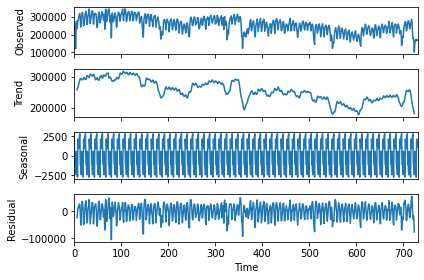

In [36]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [37]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.862083
p-value                          0.350103
#Lags Used                      19.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


In [0]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

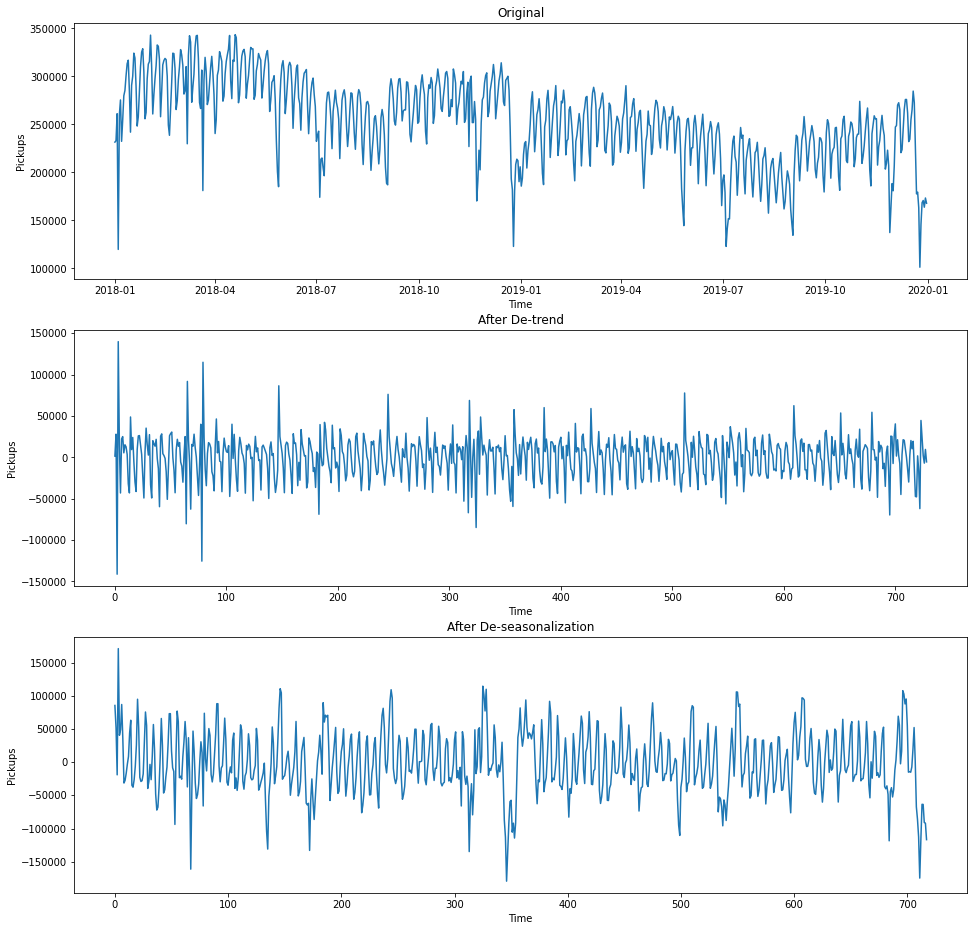

In [43]:
ts=data.groupby(["time"])["pickups"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Pickups')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Pickups')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [40]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.981551e+00
p-value                        2.615200e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.970000e+02
Critical Value (1%)           -3.439767e+00
Critical Value (5%)           -2.865696e+00
Critical Value (10%)          -2.568983e+00
dtype: float64


<b> Now the p value is less than 0.05</b>

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

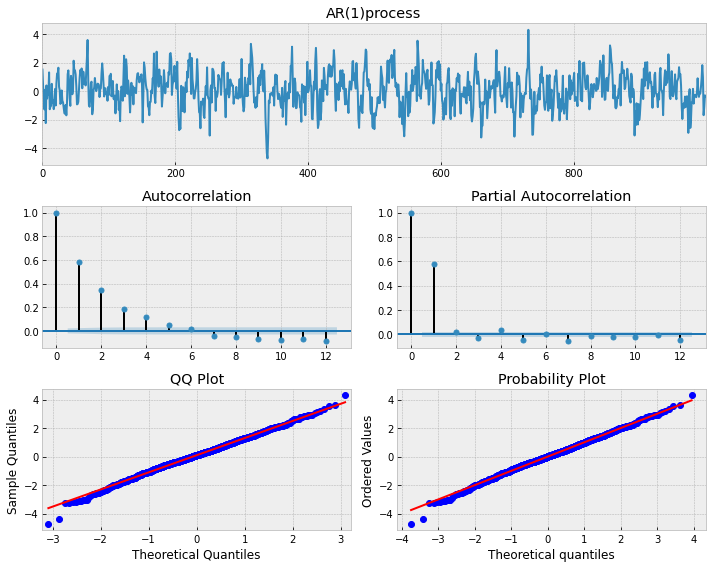

In [45]:
import numpy as np
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

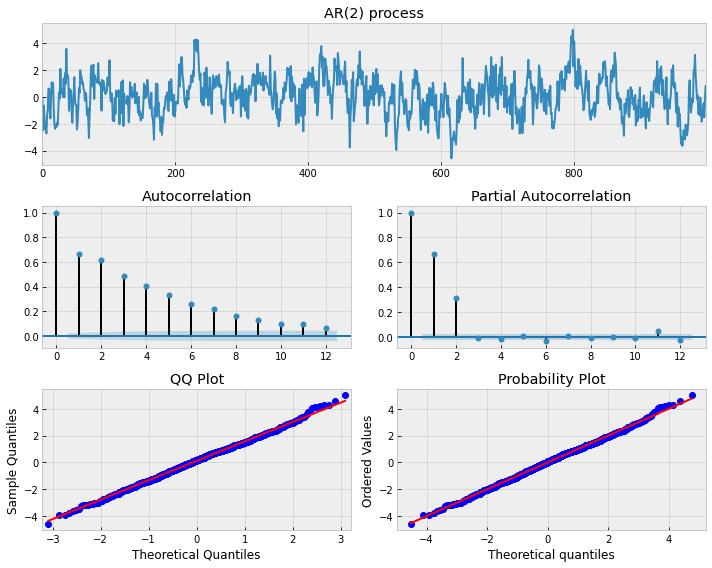

In [46]:
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

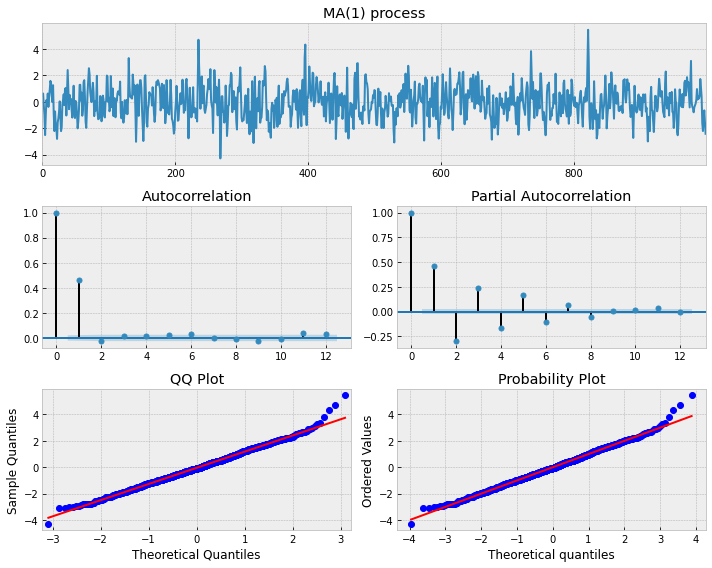

In [47]:
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

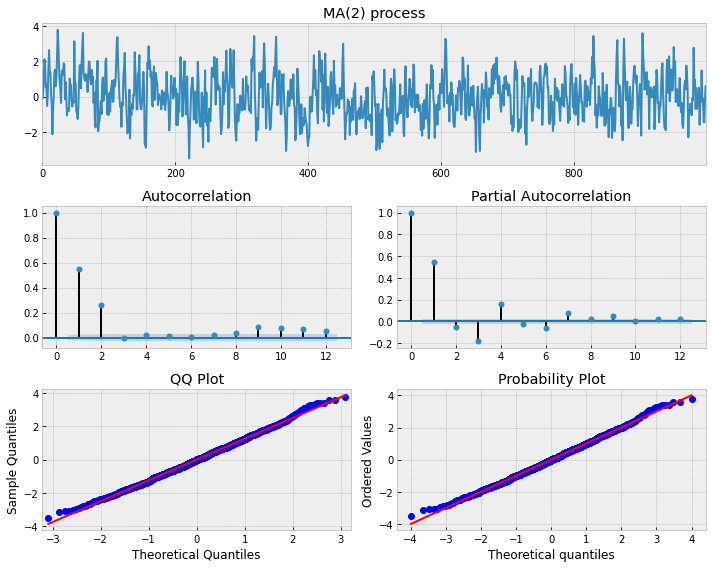

In [48]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

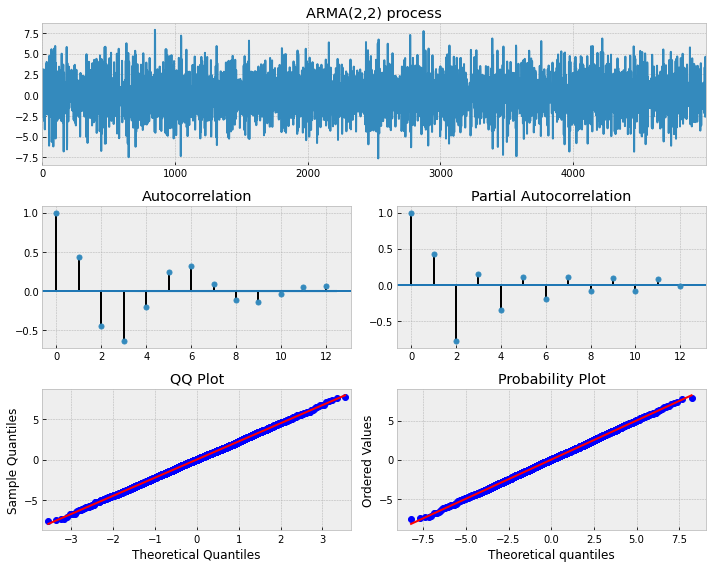

In [49]:
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [50]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


In [0]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 16754.26676 | order: (4, 4)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [51]:
best_mdl.predict()

array([ 0.        , -0.92672915, -0.03278514, ..., -0.24946959,
        3.1798043 ,  2.60872293])

In [52]:
data.head()

,pickups
time,
2018-01-01 00:00:00+00:00,231546.0
2018-01-02 00:00:00+00:00,233052.0
2018-01-03 00:00:00+00:00,261087.0
2018-01-04 00:00:00+00:00,119818.0
2018-01-05 00:00:00+00:00,259731.0


In [55]:
ts=data.groupby(["time"])["pickups"].sum()
ts.index=pd.date_range(start = '2018-01-01',end='2019-12-31', freq = 'D')
ts=ts.reset_index()
ts.head()

,index,pickups
0,2018-01-01,231546.0
1,2018-01-02,233052.0
2,2018-01-03,261087.0
3,2018-01-04,119818.0
4,2018-01-05,259731.0


In [57]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future = model.make_future_dataframe(periods = 365, freq = 'D')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2020-12-26,141432.467516,114687.319492,168283.053147
1091,2020-12-27,102642.386166,76350.568914,131115.032635
1092,2020-12-28,108557.593977,80350.226974,133816.505140
1093,2020-12-29,128098.345681,101342.958325,154028.267411
1094,2020-12-30,132913.154434,105719.958574,158905.221481


In [0]:
forecast.head()

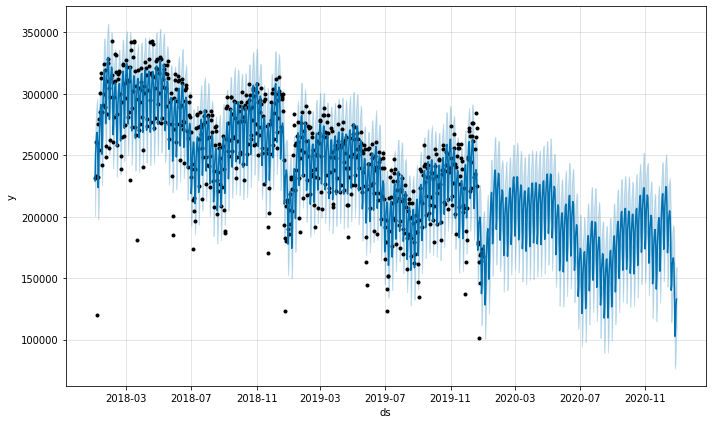

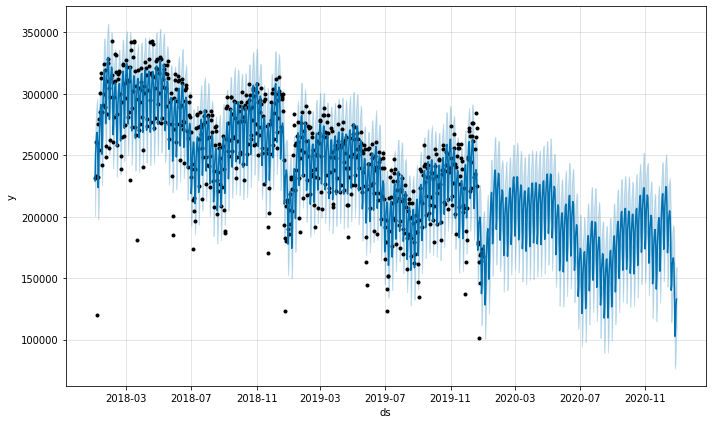

In [59]:
model.plot(forecast)

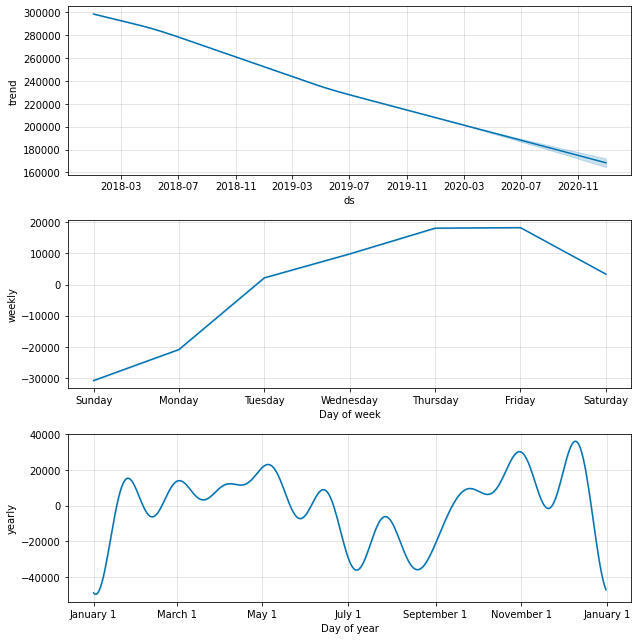

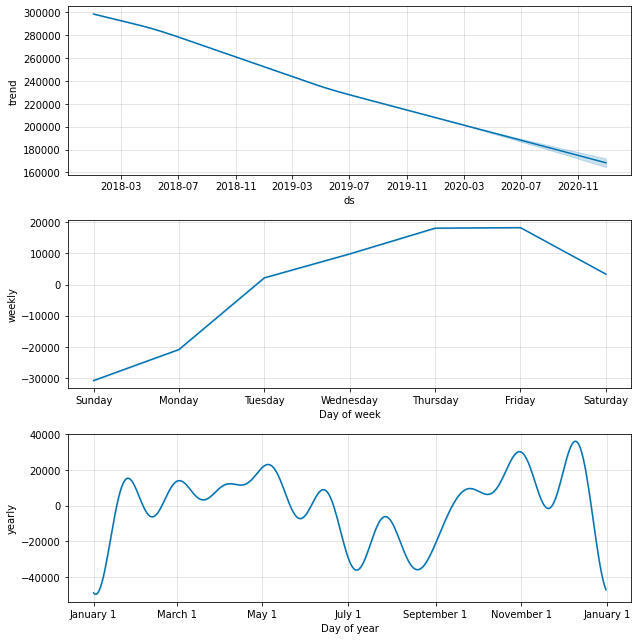

In [60]:
model.plot_components(forecast)

Different Try

In [0]:
data=df2

In [0]:
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum()

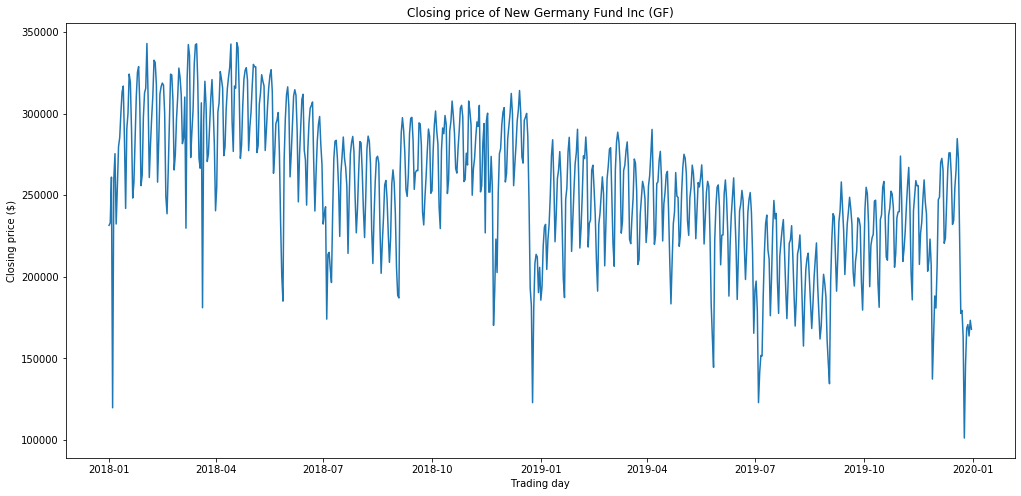

In [0]:
plt.figure(figsize=(17, 8))
plt.plot(data.pickups)
plt.title('Pickups')
plt.ylabel('Pickups')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

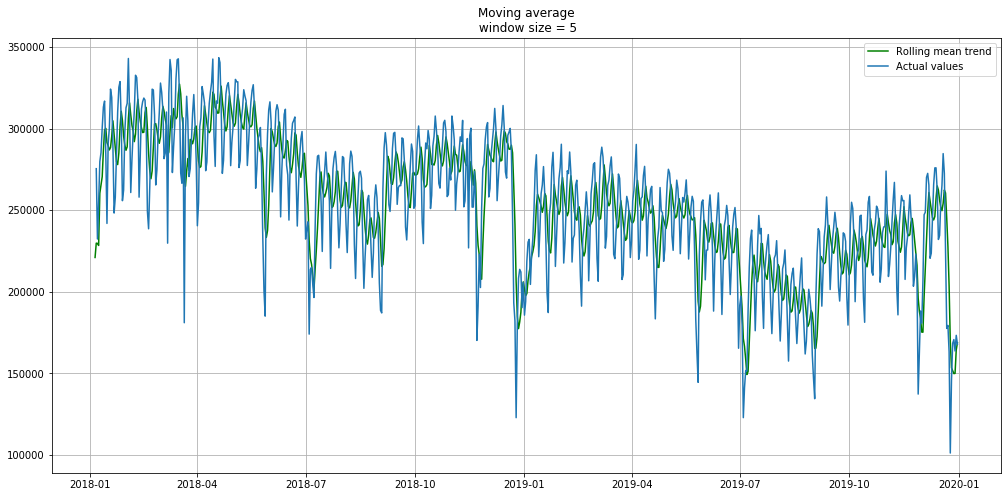

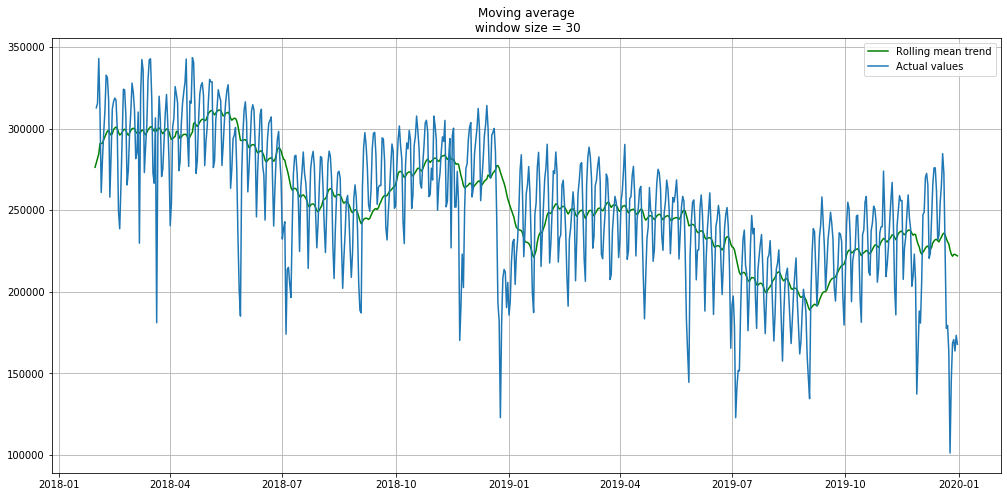

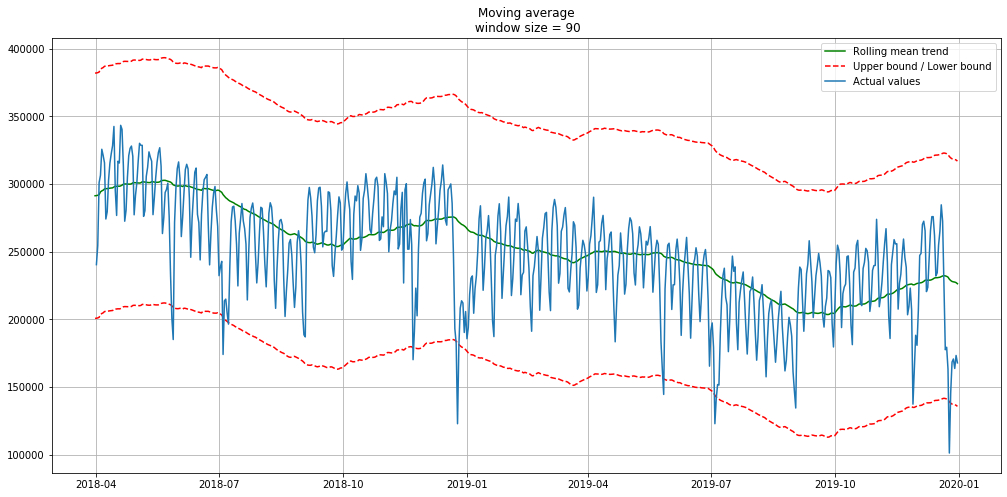

In [0]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.pickups, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.pickups, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.pickups, 90, plot_intervals=True)

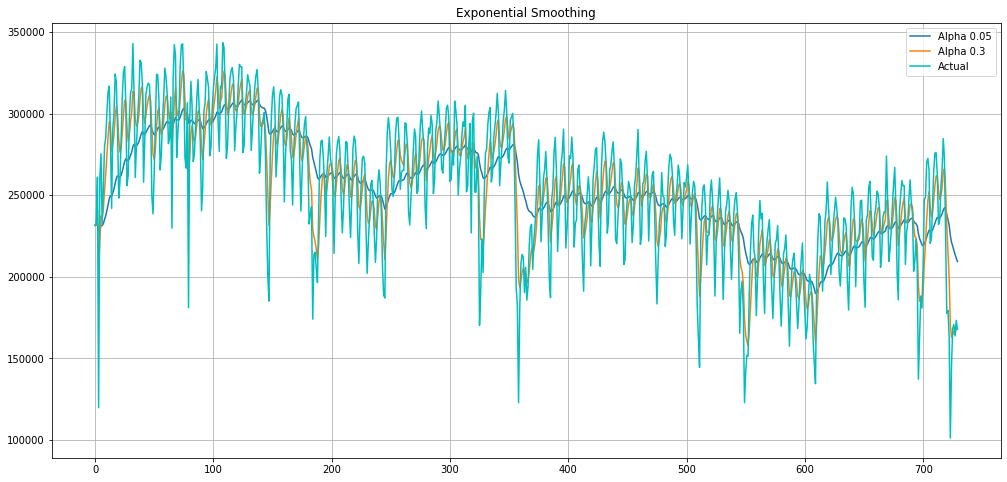

In [0]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.pickups, [0.05, 0.3])

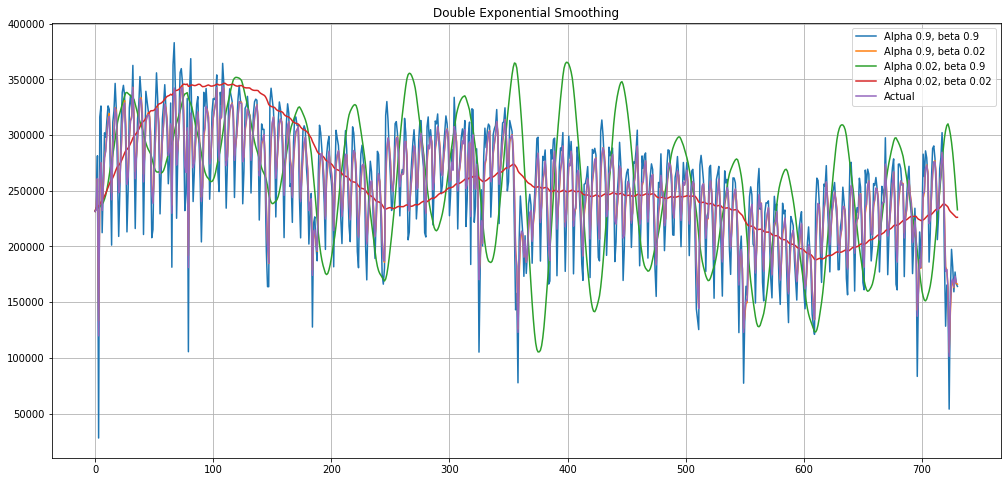

In [0]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.pickups, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [0]:
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



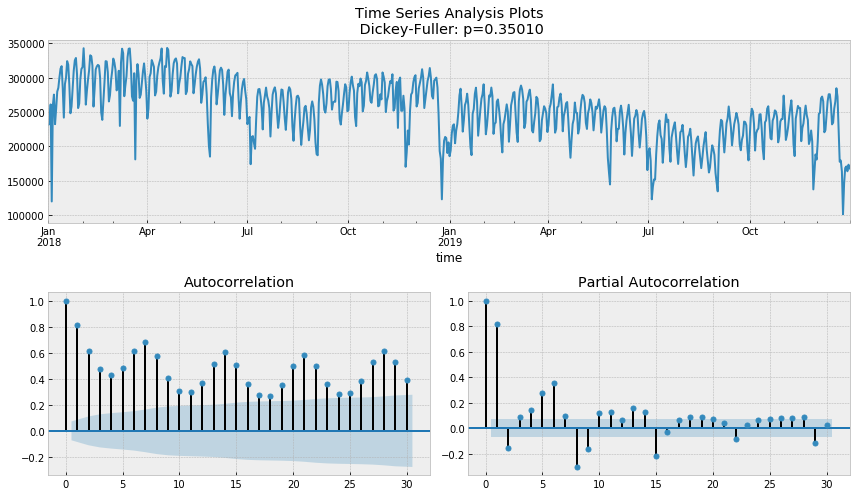

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.pickups, lags=30)

# Take the first difference to remove to make the process stationary


In [0]:
data_diff = data.pickups - data.pickups.shift(1)


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



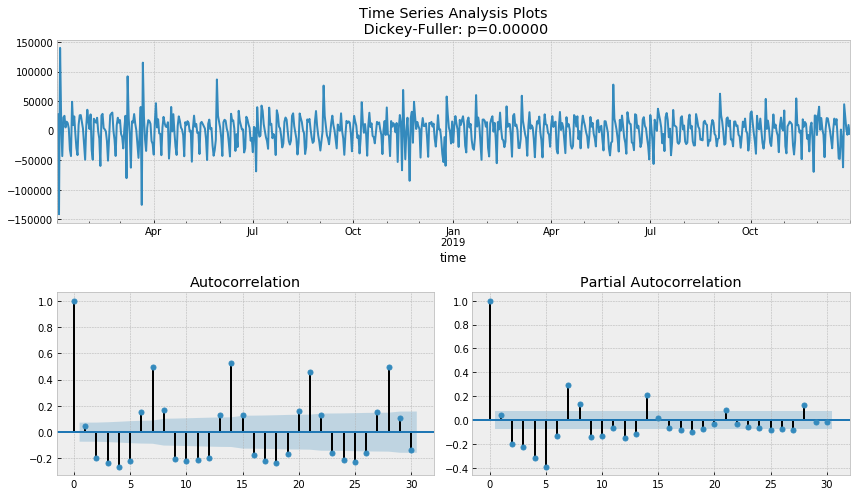

In [0]:
tsplot(data_diff[1:], lags=30)

In [0]:

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        
        try:
            print("hello")
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [0]:
from tqdm import tqdm_notebook
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [0]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [0]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [0]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [0]:
best_model = sm.tsa.statespace.SARIMAX(data.pickups, order=(1, d, 0),
                                       seasonal_order=(1, 2, 0, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                           pickups   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 5)   Log Likelihood               -8874.134
Date:                           Tue, 10 Mar 2020   AIC                          17754.268
Time:                                   05:23:10   BIC                          17768.001
Sample:                               01-01-2018   HQIC                         17759.570
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2474      0.061      4.035      0.000       0.127       0.368
ar.S.L5       -0.6258      0.037    -16.929

In [0]:
best_model

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



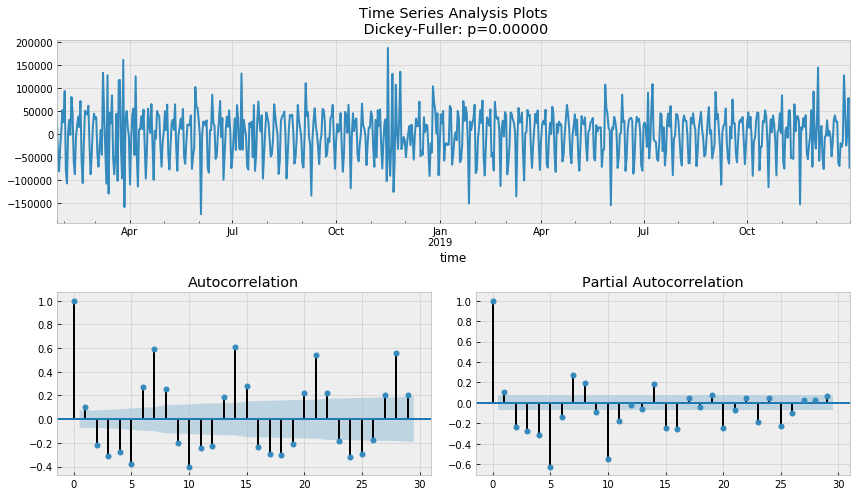

In [0]:
tsplot(best_model.resid[24+1:])

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

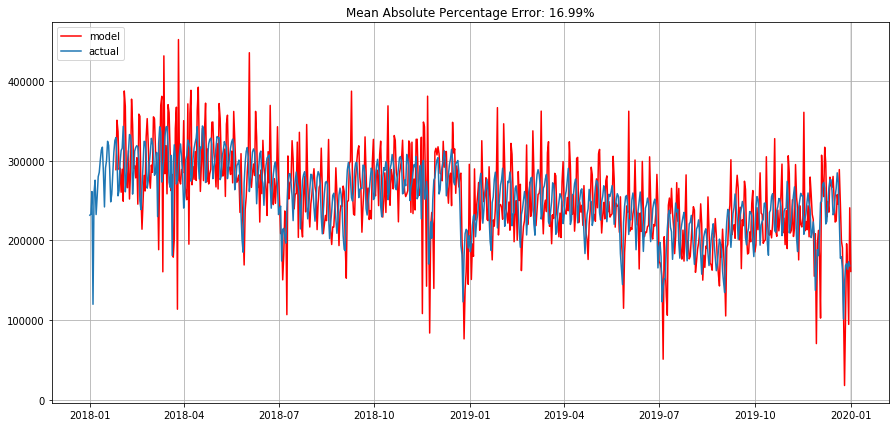

In [0]:
plotSARIMA(data, best_model, 0)

In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [0]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

In [0]:
importances = reg.feature_importances_

In [0]:
_ = plot_importance(reg, height=0.9)

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(reg, max_num_features=7, ax=ax)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [0]:
a=rf.predict(X_test)

In [0]:
import lightgbm as lgb
print("Fitting...")
parameters = gbm.fit( X_train, y_train )
print("Fitted...")